# Final version of code used for making flood return period figures in manuscript

In [1]:
import scipy as scipy
import scipy.stats as stats
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import time
import pickle 
import cartopy.crs as ccrs

from pathlib import Path
from netCDF4 import Dataset

/home/mdfowler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Make colormap 

In [2]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList = [(27,30,72), (62,86,170), (81,144,208), (104,200,220),(166,227,221), 
           (221,238,247), (248,247,100),(250,203,0),(249,81,1), (246,80,149),(242,30,15)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap = make_cmap(colorsList, bit=True)

# Load in data
* Load lat and lon from CaMa dataset
* Load return period of 100-year flood in actual dataset 

In [3]:
#Modify path to file to fit your system 
CaMaFile = Dataset('fldare1161.nc')

lat =  CaMaFile.variables['lat'][:] 
lon = CaMaFile.variables['lon'][:] 

In [4]:
#Load in original return periods 
fullData = sio.loadmat('pyTfull.mat')
Tfull    = fullData['Tfull']
radData  = sio.loadmat('pyTrad.mat')
Trad     = radData['Trad']
physData = sio.loadmat('pyTphys.mat')
Tphys    = physData['Tphys']

print(np.shape(Tfull))

# ---- LOAD RETURN PERIOD DATA ---- #
[hSigFull,hSigRad,hSigPhys]=np.load('sig95.pkl')

(1440, 720)


# Bootstrap Samples
Read in series of pickle files defined by lat/lon, containing:
* Tfull_Mean, Tfull_2_5pct, Tfull_5pct, Tfull_15pct, Tfull_85pct, Tfull_95pct, Tfull_97_5pct
* Tphys_Mean, Tphys_2_5pct, Tphys_5pct, Tphys_15pct, Tphys_85pct, Tphys_95pct, Tphys_97_5pct
* Trad_Mean,  Trad_2_5pct,  Trad_5pct,  Trad_15pct,  Trad_85pct,  Trad_95pct,  Trad_97_5pct

Filenames are in the form:
testBoot1000_lonIndex+str(i)+'_latIndex'+str(j)+.pkl

They're saved by the following command:

> *pickle.dump([Tfull_Mean, Tfull_2_5pct, Tfull_5pct, Tfull_15pct, Tfull_85pct, Tfull_95pct, Tfull_97_5pct, Tphys_Mean, Tphys_2_5pct, Tphys_5pct, Tphys_15pct, Tphys_85pct, Tphys_95pct, Tphys_97_5pct, Trad_Mean, Trad_2_5pct, Trad_5pct, Trad_15pct, Trad_85pct, Trad_95pct, Trad_97_5pct], f_myFile)*


In [6]:
fileBase = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/Bootstrap1000/testBoot1000_lonIndex'

# Define empty arrays 
Tfull_Mean    = np.full([len(lon),len(lat)],np.nan)
Tfull_2_5pct  = np.full([len(lon),len(lat)],np.nan)
# Tfull_5pct    = np.full([len(lon),len(lat)],np.nan)
# Tfull_15pct   = np.full([len(lon),len(lat)],np.nan)
# Tfull_85pct   = np.full([len(lon),len(lat)],np.nan)
# Tfull_95pct   = np.full([len(lon),len(lat)],np.nan)
Tfull_97_5pct = np.full([len(lon),len(lat)],np.nan)
Tphys_Mean    = np.full([len(lon),len(lat)],np.nan)
# Tphys_2_5pct  = np.full([len(lon),len(lat)],np.nan)
# Tphys_5pct    = np.full([len(lon),len(lat)],np.nan)
# Tphys_15pct   = np.full([len(lon),len(lat)],np.nan)
# Tphys_85pct   = np.full([len(lon),len(lat)],np.nan)
# Tphys_95pct   = np.full([len(lon),len(lat)],np.nan)
Tphys_97_5pct = np.full([len(lon),len(lat)],np.nan)
Trad_Mean     = np.full([len(lon),len(lat)],np.nan)
Trad_2_5pct   = np.full([len(lon),len(lat)],np.nan)
# Trad_5pct     = np.full([len(lon),len(lat)],np.nan)
# Trad_15pct    = np.full([len(lon),len(lat)],np.nan)
# Trad_85pct    = np.full([len(lon),len(lat)],np.nan)
# Trad_95pct    = np.full([len(lon),len(lat)],np.nan)
Trad_97_5pct  = np.full([len(lon),len(lat)],np.nan)

hSigFull = np.ones([len(lon),len(lat)])
hSigRad  = np.ones([len(lon),len(lat)])
hSigPhys = np.ones([len(lon),len(lat)])

countMiss = 0

# Loop over lon and lat to check significance
#for i in range(0, len(lon)):
for i in range(len(lon)):
    for j in range(len(lat)):
        fileName = fileBase + str(i) + '_latIndex' + str(j) + '.pkl'
        
        fileCheck = Path(fileName)
        if fileCheck.exists(): 
            fullPickle = pickle.load( open(fileName,"rb"))
        
            Tfull_Mean[i,j]    = fullPickle[0]
            Tfull_2_5pct[i,j]  = fullPickle[1]
#             Tfull_5pct[i,j]    = fullPickle[2]
#             Tfull_15pct[i,j]   = fullPickle[3]
#             Tfull_85pct[i,j]   = fullPickle[4]
#             Tfull_95pct[i,j]   = fullPickle[5]
            Tfull_97_5pct[i,j] = fullPickle[6]

            Tphys_Mean[i,j]    = fullPickle[7]
            Tphys_2_5pct[i,j]  = fullPickle[8]
#             Tphys_5pct[i,j]    = fullPickle[9]
#             Tphys_15pct[i,j]   = fullPickle[10]
#             Tphys_85pct[i,j]   = fullPickle[11]
#             Tphys_95pct[i,j]   = fullPickle[12]
            Tphys_97_5pct[i,j] = fullPickle[13]

            Trad_Mean[i,j]     = fullPickle[14]
            Trad_2_5pct[i,j]   = fullPickle[15]
#             Trad_5pct[i,j]     = fullPickle[16]
#             Trad_15pct[i,j]    = fullPickle[17]
#             Trad_85pct[i,j]    = fullPickle[18]
#             Trad_95pct[i,j]    = fullPickle[19]
            Trad_97_5pct[i,j]  = fullPickle[20]
        
#             if Tfull[i,j]>100 and Tfull_2_5pct[i,j]<100:
#                 hSigFull[i,j]=0
#             elif Tfull[i,j]<100 and Tfull_97_5pct[i,j]>100:
#                 hSigFull[i,j]=0
        
#             if Trad[i,j]>100 and Trad_2_5pct[i,j]<100:
#                 hSigRad[i,j]=0
#             elif Trad[i,j]<100 and Trad_97_5pct[i,j]>100:
#                 hSigRad[i,j]=0
        
#             if Tphys[i,j]>100 and Tphys_2_5pct[i,j]<100:
#                 hSigPhys[i,j]=0
#             elif Tphys[i,j]<100 and Tphys_97_5pct[i,j]>100:
#                 hSigPhys[i,j]=0

                
            if Tfull_Mean[i,j]>100 and Tfull_2_5pct[i,j]<100:
                hSigFull[i,j]=0
            elif Tfull_Mean[i,j]<100 and Tfull_97_5pct[i,j]>100:
                hSigFull[i,j]=0
        
            if Trad_Mean[i,j]>100 and Trad_2_5pct[i,j]<100:
                hSigRad[i,j]=0
            elif Trad_Mean[i,j]<100 and Trad_97_5pct[i,j]>100:
                hSigRad[i,j]=0
        
            if Tphys_Mean[i,j]>100 and Tphys_2_5pct[i,j]<100:
                hSigPhys[i,j]=0
            elif Tphys_Mean[i,j]<100 and Tphys_97_5pct[i,j]>100:
                hSigPhys[i,j]=0


        else:
            print("File does not exist for lon ",i, "and lat ",j)
            hSigFull[i,j]=0
            hSigRad[i,j]=0
            hSigPhys[i,j]=0

            countMiss = countMiss+1
            


KeyboardInterrupt: 

In [18]:
#i=np.where(Tphys_97_5pct == Tphys_95pct)
#np.shape(i)

In [27]:
#fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/sig95.pkl'
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/sig95_bootMeans-Oct2018.pkl'
f_myFile = open(fileName,'wb')
#pickle.dump([hSigFull, hSigRad, hSigPhys], f_myFile)
pickle.dump([hSigFull, hSigRad, hSigPhys,Tfull_Mean,Trad_Mean,Tphys_Mean], f_myFile)
f_myFile.close()




In [5]:
# ---- LOAD RETURN PERIOD DATA ---- #
[hSigFull,hSigRad,hSigPhys]=np.load('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/sig95.pkl')

In [7]:
print(countMiss)

0


# Plot significant changes in return period


In [5]:
#Apply boostrap significance 
Tfull_sig = Tfull * hSigFull
Trad_sig  = Trad * hSigRad
Tphys_sig = Tphys * hSigPhys

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [6]:
# Define array of colors for maps

#If figures are to use significance test when plotting, turn sigPlot to 1:
sigPlot = 1
if sigPlot==1:
    Tfull_col = Tfull_sig
    Trad_col  = Trad_sig
    Tphys_col = Tphys_sig
else:
    Tfull_col = Tfull
    Trad_col  = Trad
    Tphys_col = Tphys 

colorsFull = np.full([len(lon),len(lat)],np.nan)
colorsFull[np.where((Tfull_col>=2)  & (Tfull_col<=5))]     = 1
colorsFull[np.where((Tfull_col>5)   & (Tfull_col<=25))]    = 2
colorsFull[np.where((Tfull_col>25)  & (Tfull_col<=50))]    = 3
colorsFull[np.where((Tfull_col>50)  & (Tfull_col<=75))]    = 4
colorsFull[np.where((Tfull_col>75)  & (Tfull_col<=95))]    = 5
colorsFull[np.where((Tfull_col>95)  & (Tfull_col<=105))]   = 6
colorsFull[np.where((Tfull_col>105) & (Tfull_col<=125))]   = 7
colorsFull[np.where((Tfull_col>125) & (Tfull_col<=250))]   = 8
colorsFull[np.where((Tfull_col>250) & (Tfull_col<=500))]   = 9
colorsFull[np.where((Tfull_col>500) & (Tfull_col<=1000))]  = 10
colorsFull[np.where(Tfull_col>1000)]                       = 11

colorsRad = np.full([len(lon),len(lat)],np.nan)
colorsRad[np.where((Trad_col>=2)  & (Trad_col<=5))]     = 1
colorsRad[np.where((Trad_col>5)   & (Trad_col<=25))]    = 2
colorsRad[np.where((Trad_col>25)  & (Trad_col<=50))]    = 3
colorsRad[np.where((Trad_col>50)  & (Trad_col<=75))]    = 4
colorsRad[np.where((Trad_col>75)  & (Trad_col<=95))]    = 5
colorsRad[np.where((Trad_col>95)  & (Trad_col<=105))]   = 6
colorsRad[np.where((Trad_col>105) & (Trad_col<=125))]   = 7
colorsRad[np.where((Trad_col>125) & (Trad_col<=250))]   = 8
colorsRad[np.where((Trad_col>250) & (Trad_col<=500))]   = 9
colorsRad[np.where((Trad_col>500) & (Trad_col<=1000))]  = 10
colorsRad[np.where(Trad_col>1000)]                      = 11

colorsPhys = np.full([len(lon),len(lat)],np.nan)
colorsPhys[np.where((Tphys_col>=2)  & (Tphys_col<=5))]     = 1
colorsPhys[np.where((Tphys_col>5)   & (Tphys_col<=25))]    = 2
colorsPhys[np.where((Tphys_col>25)  & (Tphys_col<=50))]    = 3
colorsPhys[np.where((Tphys_col>50)  & (Tphys_col<=75))]    = 4
colorsPhys[np.where((Tphys_col>75)  & (Tphys_col<=95))]    = 5
colorsPhys[np.where((Tphys_col>95)  & (Tphys_col<=105))]   = 6
colorsPhys[np.where((Tphys_col>105) & (Tphys_col<=125))]   = 7
colorsPhys[np.where((Tphys_col>125) & (Tphys_col<=250))]   = 8
colorsPhys[np.where((Tphys_col>250) & (Tphys_col<=500))]   = 9
colorsPhys[np.where((Tphys_col>500) & (Tphys_col<=1000))]  = 10
colorsPhys[np.where(Tphys_col>1000)]                       = 11

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ip

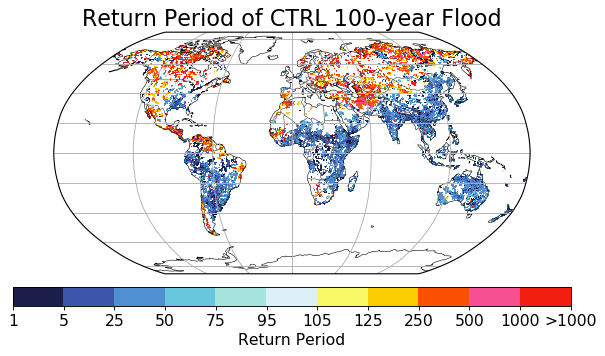

In [8]:
## PLOT TFULL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFull)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
#ax.set_title('Return period of CTRL100 Flood (95% sig): FULL')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/Python/figures/returnPeriod100_FULL.pdf',bbox_inches = 'tight')  #Save figure as PDF
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/returnPeriod100_95sig_FULL.jpg',bbox_inches = 'tight')  #Save figure as jpg

#Options used for DOE talk 
ax.set_title('Return Period of CTRL 100-year Flood')
ax.title.set_fontsize(20)




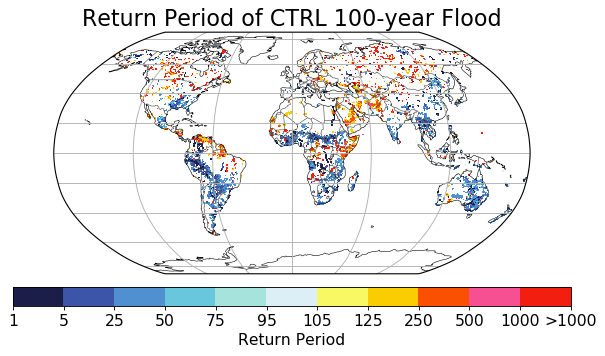

In [9]:
## PLOT TPHYS RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsPhysT = np.transpose(colorsPhys)
contour_plot = ax.pcolormesh(lon,lat,colorsPhysT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar
#Other plotting options
#ax.set_title('Return period of CTRL100 Flood (95% sig): PHYS')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Save figure 
#fig.savefig('Bootstrap95pct_returnPeriod100_PHYS.pdf')  #Save figure as PDF
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/returnPeriod100_95sig_PHYS.jpg',bbox_inches = 'tight')  #Save figure as jpg


#Options used for DOE talk 
ax.set_title('Return Period of CTRL 100-year Flood')
ax.title.set_fontsize(20)


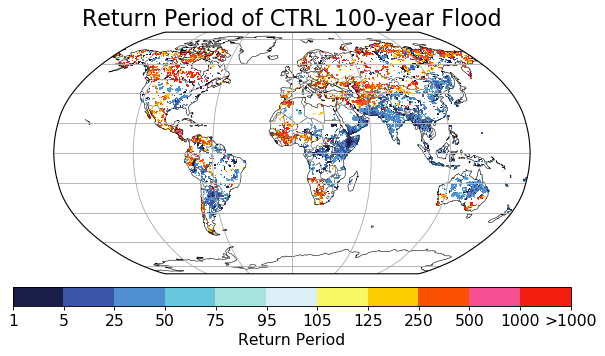

In [10]:
## PLOT TRAD RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsRadT = np.transpose(colorsRad)
contour_plot = ax.pcolormesh(lon,lat,colorsRadT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar
#Other plotting options
#ax.set_title('Return period of CTRL100 Flood (95% sig): RAD')
ax.title.set_fontsize(20)   
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#fig.savefig('Bootstrap95pct_returnPeriod100_RAD.pdf')  #Save figure as PDF
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/returnPeriod100_95sig_RAD.jpg',bbox_inches = 'tight')  #Save figure as jpg


#Options used for DOE talk 
ax.set_title('Return Period of CTRL 100-year Flood')
ax.title.set_fontsize(20)


In [28]:
if 100>np.inf:
    print('Yes, 100 is more than Inf')
else:
    print('No, 100 is less than Inf')

No, 100 is less than Inf


In [14]:
sio.savemat('pyReturnPeriod_bootstrapped90sig.mat', mdict={'Tfull': Tfull_sig, 'Tphys': Tphys_sig, 'Trad': Trad_sig})


# Compute mask of drivers
* First at CaMa Resolution
* Next at CESM Resolution

In [7]:
Tfull_sig[np.where(Tfull_sig==0)] =np.nan
Tphys_sig[np.where(Tphys_sig==0)] =np.nan
Trad_sig[np.where(Trad_sig==0)]   =np.nan

maskRaw = np.full([len(lon),len(lat)],np.nan)

In [8]:
for i in range(len(lon)):
    for j in range(len(lat)):
        fullPoint = Tfull_sig[i,j]      #Isolate single grid cell
        radPoint  = Trad_sig[i,j]
        physPoint = Tphys_sig[i,j]
        
        if np.isnan(fullPoint)==False:   #Check that this is a valid point 
            #Define mask for combination-driven regions
            if fullPoint<100 and radPoint<100 and physPoint<100: 
                dFull = 100-fullPoint
                dRad  = 100-radPoint
                dPhys = 100-physPoint 
                
                limit = 0.2*dFull 
                
                if dRad>=limit and dPhys>=limit:
                    maskRaw[i,j] = 1 #COMBO driven
                elif dRad<limit and dPhys>=limit:
                    maskRaw[i,j] = 2 #PHYS driven
                elif dRad>=limit and dPhys<limit:
                    maskRaw[i,j] = 3 #RAD driven
                else: 
                    maskRaw[i,j] = np.nan
            #Define mask for PHYS and RAD driven regions
            elif fullPoint<100 and radPoint>100 and physPoint<100:
                maskRaw[i,j] = 2 #PHYS driven 
            elif fullPoint<100 and radPoint<100 and physPoint>100:
                maskRaw[i,j] = 3 #RAD driven  
            elif fullPoint<100 and physPoint<100 and np.isnan(radPoint)==True:
                maskRaw[i,j] = 2 #PHYS driven
            elif fullPoint<100 and radPoint<100 and np.isnan(physPoint)==True:
                maskRaw[i,j] = 3 #RAD driven 
            
            


In [17]:
sio.savemat('pyMask_CAMAres_95sig.mat', mdict={'maskRaw': maskRaw})

**Average return period of CTRL100 flood in regions specified**

In [9]:
# - Apply mask for which driver we care about; so, select only orange gridcells, for example - #

Tfull_masked = np.full([len(lon),len(lat)],np.nan)
Tphys_masked = np.full([len(lon),len(lat)],np.nan)
Trad_masked = np.full([len(lon),len(lat)],np.nan)

for ilon in range(len(lon)):
    for ilat in range(len(lat)):
        if maskRaw[ilon,ilat]==3:      ### This is the line to change for specifying which driver region is being assessed 
            Tfull_masked[ilon,ilat] = Tfull_sig[ilon,ilat]
            Tphys_masked[ilon,ilat] = Tphys_sig[ilon,ilat]
            Trad_masked[ilon,ilat]  = Trad_sig[ilon,ilat]
            

In [10]:
# - Define domain that describes region - 
#SE US - combo driven 
# ilon = np.where((lon>-97)&(lon<-85))
# ilat = np.where((lat>28)&(lat<37))
#SE Asia - combo driven 
# ilon = np.where((lon>94)&(lon<108))
# ilat = np.where((lat>11)&(lat<24))
#Central Australia - combo driven 
# ilon = np.where((lon>135)&(lon<145))
# ilat = np.where((lat>-32)&(lat<-19))

#W Amazon - PHYS-driven 
# ilon = np.where((lon>-82)&(lon<-59))
# ilat = np.where((lat>-18)&(lat<3))
#Central Africa - PHYS-driven
# ilon = np.where((lon>-11)&(lon<32))
# ilat = np.where((lat>3)&(lat<14))
#SE Australia - PHYS-driven
# ilon = np.where((lon>137)&(lon<153))
# ilat = np.where((lat>-43)&(lat<-27))

# India - RAD-driven
# ilon = np.where((lon>54)&(lon<99))
# ilat = np.where((lat>17)&(lat<33))
# E Africa - RAD-driven
ilon = np.where((lon>11)&(lon<51))
ilat = np.where((lat>-7)&(lat<11))

#Isolate that region in FULL,PHYS,RAD
selFull  = Tfull_masked[ilon[0][:],:]
selFull  = selFull[:,ilat[0][:]]
selFull[np.where(selFull>1e40)]  = np.nan    #Some return periods are +inf, so eliminate those 
meanFull = np.nanmean(np.nanmean(selFull))

selPhys  = Tphys_masked[ilon[0][:],:]
selPhys  = selPhys[:,ilat[0][:]]
selPhys[np.where(selPhys>1e40)]  = np.nan    #Some return periods are +inf, so eliminate those 
meanPhys = np.nanmean(np.nanmean(selPhys))

selRad   = Trad_masked[ilon[0][:],:]
selRad   = selRad[:,ilat[0][:]]
selRad[np.where(selRad>1e40)]  = np.nan    #Some return periods are +inf, so eliminate those 
meanRad  = np.nanmean(np.nanmean(selRad))

#Print out results
print('Mean return period in FULL: ', meanFull)
print('Mean return period in PHYS: ', meanPhys)
print('Mean return period in RAD:  ', meanRad)



Mean return period in FULL:  16.87426342960525
Mean return period in PHYS:  337.4776693909935
Mean return period in RAD:   15.529283621951937


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


* Plot mask in original CaMa resolution

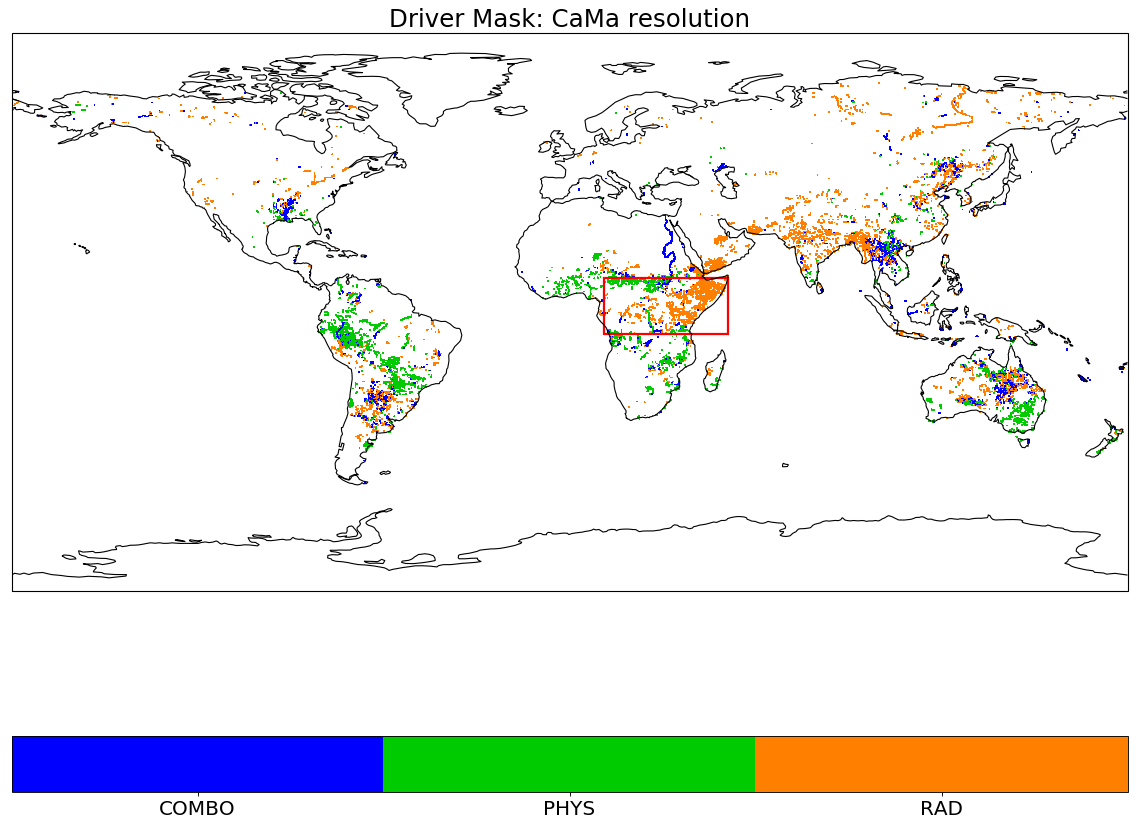

In [11]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')


# Make Colormap
colorsList = [(0,0,255), (0,204,0), (255,128,0)]

my_cmap = make_cmap(colorsList, bit=True)

## --- Set axes and color sections --- 
#ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ax.set_global()
bounds = [1,2,3,4]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
maskRawT = np.transpose(maskRaw)
contour_plot = ax.pcolormesh(lon,lat,maskRawT,norm=norm,cmap=my_cmap,vmin=1,vmax=3)
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(4))
cbar.set_ticks([1.5,2.5,3.5])
cbar.ax.set_xticklabels(['COMBO','PHYS','RAD'],fontsize=18)  

ax.set_title('Driver Mask: CaMa resolution')
ax.title.set_fontsize(22)
    
ax.coastlines()

# rect = patches.Rectangle((94,11),14,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE Asia
# ax.add_patch(rect)
rect = patches.Rectangle((11,-7),40,18,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #Horn of Africa
ax.add_patch(rect)



* Convert to CESM resolution mask by taking the mode of all CaMa gridcells within a single CESM grid cell 

In [12]:
cesmFile = Dataset('cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyConcat_Meg.nc')
# print(CaMaFile.dimensions.keys())|

cesmLat = cesmFile.variables['lat'][:] 
cesmLon = cesmFile.variables['lon'][:] 

# Convert longitude from 0:360 to -180:180 
numlon = len(cesmLon)
delt_lon = cesmLon[2] - cesmLon[1]
nlon = np.linspace(-180,(180-delt_lon),num=numlon,endpoint=True)

#Find resolution of lat and lon in CESM
dlon = nlon[2] - nlon[1]
dlat = cesmLat[2] - cesmLat[1]

#CaMa resolution
dlonCAMA = lon[2] - lon[1]
dlatCAMA = lat[2] - lat[1]



In [13]:
physMask = np.full([len(nlon),len(cesmLat)],np.nan)
equalFlag = np.zeros([len(nlon),len(cesmLat)])

for i in range(len(nlon)): 
    for j in range(len(cesmLat)):
        lonLeft   = nlon[i]
        lonRight  = nlon[i]+dlon 
        latBottom = cesmLat[j]
        latTop    = cesmLat[j]+dlat
        
        ilon = np.where(((lon-dlonCAMA/2)>=lonLeft) & ((lon+dlonCAMA/2)<lonRight))
        ilat = np.where(((lat+dlatCAMA/2)>=latBottom) & ((lat-dlatCAMA/2)<latTop))
        
        maskSection = np.squeeze(maskRaw[ilon][:,ilat])
        
        if np.sum(np.isnan(maskSection)) != np.size(maskSection):   #If not ALL NaN's 
            physMask[i,j] = stats.mode(maskSection,axis=None,nan_policy='omit')[0]
            
            #Flag data if some are equal
            count1 = np.where(maskSection==1)
            count2 = np.where(maskSection==2)
            count3 = np.where(maskSection==3)
            
            if np.size(count1)==np.size(count2) and np.size(count1)>0:
                equalFlag[i,j] = 1
                physMask[i,j]  = np.nan
            elif np.size(count1)==np.size(count3) and np.size(count3)>0:
                equalFlag[i,j] = 1
                physMask[i,j]  = np.nan 
            elif np.size(count2)==np.size(count3) and np.size(count2)>0:
                equalFlag[i,j] = 1
                physMask[i,j]  = np.nan
            

In [14]:
pnt0 = np.where(nlon==0)

print(pnt0)

physMaskNew                      = np.full([len(cesmLon),len(cesmLat)],np.nan)
physMaskNew[0:int(pnt0[0])-1,:]  = physMask[int(pnt0[0]):-1,:]
physMaskNew[int(pnt0[0]):-1,:]   = physMask[0:int(pnt0[0])-1,:]

#physMaskNew = [physMask[int(pnt0[0]):-1,:]; physMask[1:int(pnt0[0])-1,:]]


np.shape(physMaskNew)
#Save output as .mat file


(array([144]),)


(288, 192)

* Plot mask in CESM resolution 

In [9]:
# Load in existing physMaskNew if not created above
mData = sio.loadmat('pyMask_CESMres_95sig.mat')
physMaskNew = mData['physMaskNew']


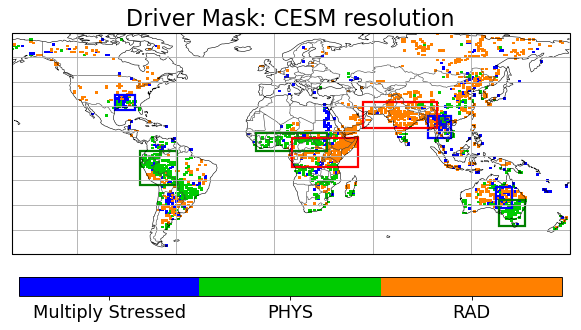

In [31]:
fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')

# Make Colormap
colorsList1 = [(0,0,255), (0,204,0), (255,128,0)]
my_cmap1 = make_cmap(colorsList1, bit=True)

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())   #Set projection to ccrs.Robinson to match previous version
#ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
#ax.set_global() 
ax.set_extent([-160,180,-60,75], crs=ccrs.PlateCarree())   #Set to global ot match previous version
bounds = [1,2,3,4]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
PhysMaskT = np.transpose(physMaskNew)
contour_plot = ax.pcolormesh(cesmLon,cesmLat,PhysMaskT,norm=norm,cmap=my_cmap1,vmin=1,vmax=3,transform=ccrs.PlateCarree())
#Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.1, ax_position.width-0.02, 0.06]) #Remove colorbar edits to width/x0 to match previous version
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(4),cax=cbar_ax)
cbar.set_ticks([1.5,2.5,3.5])
cbar.ax.set_xticklabels(['Multiply Stressed','PHYS','RAD'],fontsize=16)  

ax.set_title('Driver Mask: CESM resolution')
ax.title.set_fontsize(20)
    
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


## Add rectangles for each region 
#     Combination-driven regions
rect = patches.Rectangle((-97,28),12,9,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax.add_patch(rect)
rect = patches.Rectangle((94,11),14,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE Asia
ax.add_patch(rect)
rect = patches.Rectangle((135,-32),10,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())  #Central Australia
ax.add_patch(rect)
#      PHYS-driven regions
rect = patches.Rectangle((-82,-18),23,21,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())  #Western Amazon
ax.add_patch(rect)
rect = patches.Rectangle((-11,3),43,11,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #Sahel
ax.add_patch(rect)
rect = patches.Rectangle((137,-43),16,16,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE Australia
ax.add_patch(rect)
#      RAD-driven regions
rect = patches.Rectangle((54,17),45,16,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #India
ax.add_patch(rect)
rect = patches.Rectangle((11,-7),40,18,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #Horn of Africa
ax.add_patch(rect)


fig.savefig('MaskDriver_CESMres_V2.eps',bbox_inches = 'tight')  #Save figure as jpg



In [23]:
sio.savemat('pyMask_CESMres_95sig.mat', mdict={'physMaskNew': physMaskNew})


## Make a single 4-panel figure for Fig. 2 in Flood/Phys paper 
* Panel 1: CTRL100 return period in full, with label (a) 
* Panel 2: CTRL100 return period in Phys, with label (b)
* Panel 3: CTRL100 return period in Rad, with label (c) and colorbar
* Panel 4: Mask of main flood drivers of FULL flood frequency, with colorbar and label (d)


In [ ]:
my_fontsize = 8

#Define figure with 4 subplots
map_crs = ccrs.Robinson()
fig, ax_array = plt.subplots(2,2,subplot_kw={'projection':map_crs})
ax1,ax2,ax3,ax4 = ax_array.flatten()
fig.set_size_inches(8,7)
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

#Set up the background map, coastlines, grids, etc. 
ax1.set_global()
ax2.set_global()
ax3.set_global()
ax4.set_global()
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax2.gridlines()
ax3.gridlines()
ax4.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


## --- Create Plot for (a) ---
colorsFullT = np.transpose(colorsFull)
contour_plot = ax1.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
ax1.set_title('(a) Return period of CTRL100 Flood: FULL - 95% sig')
ax1.title.set_fontsize(my_fontsize)

## --- Create Plot for (b) ---
colorsPhysT = np.transpose(colorsPhys)
contour_plot = ax2.pcolormesh(lon,lat,colorsPhysT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
ax2.set_title('(b) Return period of CTRL100 Flood: PHYS - 95% sig')
ax2.title.set_fontsize(my_fontsize)

## --- Create Plot for (c) ---
colorsRadT = np.transpose(colorsRad)
contour_plot = ax3.pcolormesh(lon,lat,colorsRadT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
ax3.set_title('(c) Return period of CTRL100 Flood: RAD - 95% sig')
ax3.title.set_fontsize(my_fontsize)
# Colorbar options
ax_position = ax3.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar


#Save figure
fig.savefig('Fig2_4subplots.pdf',bbox_inches = 'tight')  #Save figure as PDF


In [ ]:
## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
colorsFullT = np.transpose(colorsFull)
contour_plot = ax.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('Return period of CTRL100 Flood: FULL - 95% sig')
ax.title.set_fontsize(my_fontsize)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



## Make figure similar to Fig 1a in H13, using data from Yukiko Hirabayashi (thank you!) 

In [10]:
h13File = Dataset('H13_multimodel_median_100years_return_period_rcp85.nc')
# print(CaMaFile.dimensions.keys())|

latH = h13File.variables['lat'][:] 
lonH = h13File.variables['lon'][:] 
h13dat = h13File.variables['Band1'][:,:]

### NOTE: This data is not incuded in the GitHub repository. Request access through Y. Hirabayashi. 


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [11]:
colorsH13 = np.full([len(lat),len(lon)],np.nan)
colorsH13[np.where((h13dat>=2)  & (h13dat<=5))]     = 1
colorsH13[np.where((h13dat>5)   & (h13dat<=25))]    = 2
colorsH13[np.where((h13dat>25)  & (h13dat<=50))]    = 3
colorsH13[np.where((h13dat>50)  & (h13dat<=75))]    = 4
colorsH13[np.where((h13dat>75)  & (h13dat<=95))]    = 5
colorsH13[np.where((h13dat>95)  & (h13dat<=105))]   = 6
colorsH13[np.where((h13dat>105) & (h13dat<=125))]   = 7
colorsH13[np.where((h13dat>125) & (h13dat<=250))]   = 8
colorsH13[np.where((h13dat>250) & (h13dat<=500))]   = 9
colorsH13[np.where((h13dat>500) & (h13dat<=1000))]  = 10
colorsH13[np.where(h13dat>1000)]                    = 11

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in 

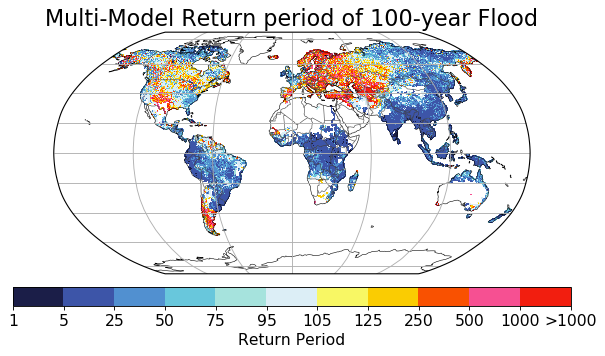

In [9]:
## PLOT H13 MULTI-MODEL RETURN PERIOD

fig=plt.figure(figsize=(9, 4), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lonH,latH,colorsH13,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=14)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=14)  # vertically oriented colorbar

#Other figure options
ax.set_title('Multi-Model Return period of 100-year Flood')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Save figure
fig.savefig('H13_MultiModelReturnPeriod.jpg',bbox_inches = 'tight')  #Save figure as PDF


## Figures for manuscript

* Figure with FULL change (no significance testing) and H13 multi-model mean change 

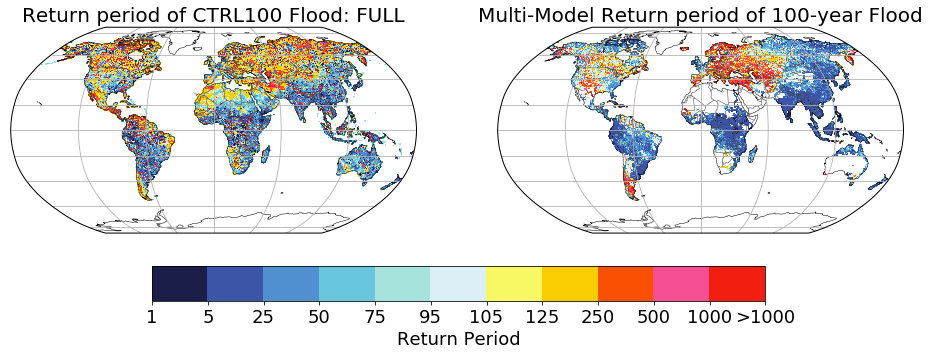

In [18]:
# --- Set up figure window --- 
fig, ax_array = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2 = ax_array.flatten()
fig.set_size_inches(16,12)
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


#Subplot 1: TFULL 
ax1.set_global
colorsFullT = np.transpose(colorsFull)
contour_plot = ax1.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax1.set_title('Return period of CTRL100 Flood: FULL')
ax1.title.set_fontsize(20)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Subplot 2: H13
contour_plot = ax2.pcolormesh(lonH,latH,colorsH13,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0+0.18, ax_position.width+0.18, 0.04])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=18)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=18)  # vertically oriented colorbar
#Other figure options
ax2.set_title('Multi-Model Return period of 100-year Flood')
ax2.title.set_fontsize(20)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



* Figure with all four bootstrapped flood changes

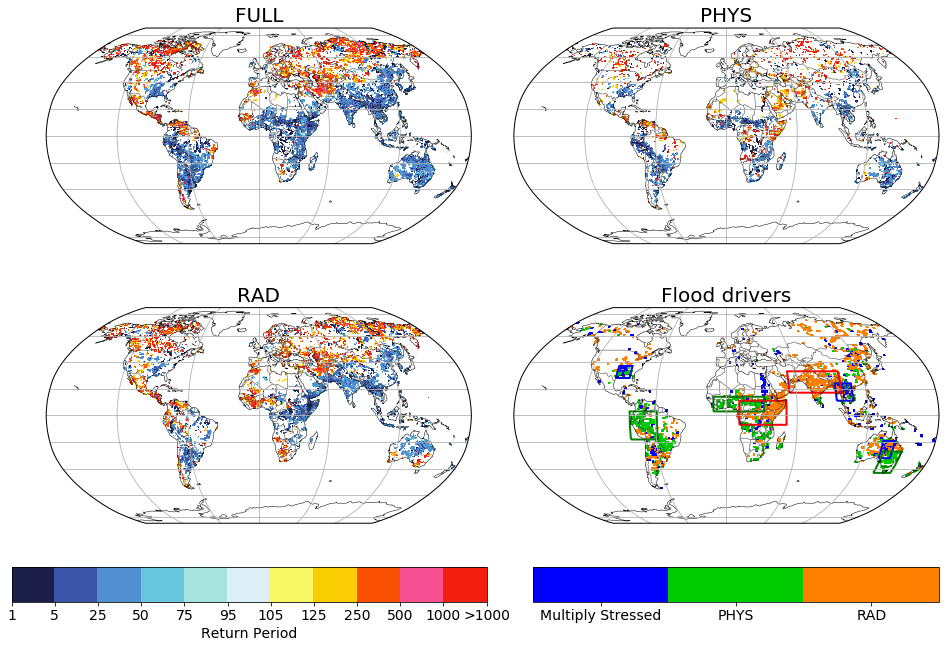

In [29]:
# 

# --- Set up figure window --- 
fig, ax_array = plt.subplots(2,2,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## Subplot 1: TFULL
colorsFullT = np.transpose(colorsFull)
contour_plot = ax1.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
# ax_position = ax.get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
# cbar.set_label('Return Period',fontsize=my_fontsize)
# cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar
#Additional options 
ax1.set_title('FULL')
ax1.title.set_fontsize(20)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

## Subplot 2: TPHYS
colorsPhysT = np.transpose(colorsPhys)
contour_plot = ax2.pcolormesh(lon,lat,colorsPhysT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax2.set_title('PHYS')
ax2.title.set_fontsize(20)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

## Subplot 3: TRAD
colorsRadT = np.transpose(colorsRad)
contour_plot = ax3.pcolormesh(lon,lat,colorsRadT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax3.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0, ax_position.width+0.06, 0.04])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=14)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=14)  # vertically oriented colorbar
#Additional options 
ax3.set_title('RAD')
ax3.title.set_fontsize(20)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

## Subplot 4: Driver mask
colorsList1 = [(0,0,255), (0,204,0), (255,128,0)]
my_cmap1 = make_cmap(colorsList1, bit=True)
ax4.set_global()
bounds = [1,2,3,4]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
## --- Create Plot ---
PhysMaskT = np.transpose(physMaskNew)
contour_plot = ax4.pcolormesh(cesmLon,cesmLat,PhysMaskT,norm=norm,cmap=my_cmap1,vmin=1,vmax=3,transform=ccrs.PlateCarree())
#Colorbar
ax_position = ax4.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.04])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(4),cax=cbar_ax)
cbar.set_ticks([1.5,2.5,3.5])
cbar.ax.set_xticklabels(['Multiply Stressed','PHYS','RAD'],fontsize=14)  
#Other plot options 
ax4.set_title('Flood drivers')
ax4.title.set_fontsize(20)   
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
## Add rectangles for each region 
#     Combination-driven regions
rect = patches.Rectangle((-97,28),12,9,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax4.add_patch(rect)
rect = patches.Rectangle((94,11),14,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE Asia
ax4.add_patch(rect)
rect = patches.Rectangle((135,-32),10,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())  #Central Australia
ax4.add_patch(rect)
#      PHYS-driven regions
rect = patches.Rectangle((-82,-18),23,21,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())  #Western Amazon
ax4.add_patch(rect)
rect = patches.Rectangle((-11,3),43,11,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #Sahel
ax4.add_patch(rect)
rect = patches.Rectangle((137,-43),16,16,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE Australia
ax4.add_patch(rect)
#      RAD-driven regions
rect = patches.Rectangle((54,17),45,16,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #India
ax4.add_patch(rect)
rect = patches.Rectangle((11,-7),40,18,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #Horn of Africa
ax4.add_patch(rect)




fig.subplots_adjust(wspace=0.1, hspace=-0.25)


## Combine into single figure for manuscript


In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(311,projection=ccrs.Robinson())
ax2 = fig.add_subplot(323,projection=ccrs.Robinson())
ax3 = fig.add_subplot(324,projection=ccrs.Robinson())
ax4 = fig.add_subplot(325,projection=ccrs.Robinson())
ax5 = fig.add_subplot(326,projection=ccrs.Robinson())

fig.set_size_inches(11,8)
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig.subplots_adjust(wspace=-0.1, hspace=0.5)


# -- Subplot 2: Tfull (CESM) -- #
colorsFullT = np.transpose(colorsFull)
contour_plot = ax2.pcolormesh(lon,lat,colorsFullT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax2.set_title('b',{'fontweight' :'bold','fontsize':16},loc='left')
#ax2.set_title('FULL')
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# -- Subplot 3: H13 -- #
contour_plot = ax3.pcolormesh(lonH,latH,colorsH13,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Other figure options
ax3.set_title('c',{'fontweight' :'bold','fontsize':16},loc='left')
#ax3.set_title('Multi-Model Return Period')
ax3.title.set_fontsize(16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# -- Subplot 4: Tphys -- #
colorsPhysT = np.transpose(colorsPhys)
contour_plot = ax4.pcolormesh(lon,lat,colorsPhysT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax4.set_title('d',{'fontweight' :'bold','fontsize':16},loc='left')
#ax4.set_title('PHYS')
ax4.title.set_fontsize(16)
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# -- Subplot 5: Trad -- #
colorsRadT = np.transpose(colorsRad)
contour_plot = ax5.pcolormesh(lon,lat,colorsRadT,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=14)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=11)  # vertically oriented colorbar
#Additional options 
ax5.set_title('e',{'fontweight' :'bold','fontsize':16},loc='left')
#ax5.set_title('RAD')
ax5.title.set_fontsize(16)
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# -- Subplot 1: Map of drivers --- #
colorsList1 = [(0,0,255), (0,204,0), (255,128,0)]
my_cmap1 = make_cmap(colorsList1, bit=True)
ax1.set_global()
bounds = [1,2,3,4]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
## --- Create Plot ---
PhysMaskT = np.transpose(physMaskNew)
contour_plot = ax1.pcolormesh(cesmLon,cesmLat,PhysMaskT,norm=norm,cmap=my_cmap1,vmin=1,vmax=3,transform=ccrs.PlateCarree())
#Colorbar
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.24, ax_position.y0-0.04, ax_position.width-0.49, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(4),cax=cbar_ax)
cbar.set_ticks([1.5,2.5,3.5])
cbar.ax.set_xticklabels(['Multiply Stressed','PHYS','RAD'],fontsize=12)  
#Other plot options 
ax1.set_title('a',{'fontweight' :'bold','fontsize':16},loc='left')
#ax1.set_title('Flood drivers')
ax1.title.set_fontsize(16)   
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
## Add rectangles for each region 
#     Combination-driven regions
rect = patches.Rectangle((-97,28),12,9,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax1.add_patch(rect)
rect = patches.Rectangle((94,11),14,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE Asia
ax1.add_patch(rect)
rect = patches.Rectangle((135,-32),10,13,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())  #Central Australia
ax1.add_patch(rect)
#      PHYS-driven regions
rect = patches.Rectangle((-82,-18),23,21,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())  #Western Amazon
ax1.add_patch(rect)
rect = patches.Rectangle((-11,3),43,11,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #Sahel
ax1.add_patch(rect)
rect = patches.Rectangle((137,-43),16,16,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE Australia
ax1.add_patch(rect)
#      RAD-driven regions
rect = patches.Rectangle((54,17),45,16,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #India
ax1.add_patch(rect)
rect = patches.Rectangle((11,-7),40,18,linewidth=2,edgecolor='r',facecolor='none', transform=ccrs.PlateCarree())    #Horn of Africa
ax1.add_patch(rect)


#Save figure
fig.savefig('Figure1_Oct2018-TEST.eps',bbox_inches = 'tight')  #Save figure as pdf
